In [1]:
import sklearn.datasets
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torch

import sklearn.model_selection
from rtdl_revisiting_models import MLP, ResNet, FTTransformer
from sklearn.metrics import r2_score, accuracy_score
from imodels import FIGSRegressor, FIGSClassifier
from imodels.importance import RandomForestPlusRegressor

from tabdl import *

import openml
from ucimlrepo import fetch_ucirepo 

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.base import clone
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

import os

from binary_mapper_utils import binary_map, bit_repr, get_leaf_node_indices
from binary_mapper import *

In [3]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

# Load the California housing dataset
# housing = fetch_california_housing(as_frame=True)

# # Create DataFrames for X and y
# X = housing.data
# y = housing.target

miami_housing = openml.datasets.get_dataset(43093)
X, y, _, _ = miami_housing.get_data(target=miami_housing.default_target_attribute, dataset_format="dataframe")
X = pd.DataFrame(X.values, columns=X.columns, index=X.index)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)

# Print the shapes of the resulting splits
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (10449, 16)
X_test shape: (2787, 16)
y_train shape: (10449,)
y_test shape: (2787,)


In [4]:
X

,LATITUDE,LONGITUDE,PARCELNO,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,HWY_DIST,age,avno60plus,month_sold,structure_quality
0,25.891031,-80.160561,6.222801e+11,9375.0,1753.0,0.0,2815.9,12811.4,347.6,42815.3,37742.2,15954.9,67.0,0.0,8.0,4.0
1,25.891324,-80.153968,6.222801e+11,9375.0,1715.0,0.0,4359.1,10648.4,337.8,43504.9,37340.5,18125.0,63.0,0.0,9.0,4.0
2,25.891334,-80.153740,6.222801e+11,9375.0,2276.0,49206.0,4412.9,10574.1,297.1,43530.4,37328.7,18200.5,61.0,0.0,2.0,4.0
3,25.891765,-80.152657,6.222801e+11,12450.0,2058.0,10033.0,4585.0,10156.5,0.0,43797.5,37423.2,18514.4,63.0,0.0,9.0,4.0
4,25.891825,-80.154639,6.222801e+11,12800.0,1684.0,16681.0,4063.4,10836.8,326.6,43599.7,37550.8,17903.4,42.0,0.0,7.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13927,25.783130,-80.259795,1.313200e+11,6780.0,967.0,6580.0,3844.5,20568.0,3252.4,22175.9,12150.1,917.4,16.0,0.0,4.0,4.0
13928,25.783585,-80.260354,1.313200e+11,7500.0,1854.0,2544.0,3593.6,20791.9,3077.7,22375.1,12316.8,738.2,26.0,0.0,5.0,4.0
13929,25.783793,-80.256126,1.313200e+11,8460.0,1271.0,2064.0,4143.2,20307.9,3588.4,20966.9,12433.0,743.7,16.0,0.0,7.0,4.0
13930,25.784007,-80.257542,1.313200e+11,7500.0,1613.0,3136.0,3986.9,20542.6,3589.1,21475.6,12458.0,626.1,16.0,0.0,8.0,4.0


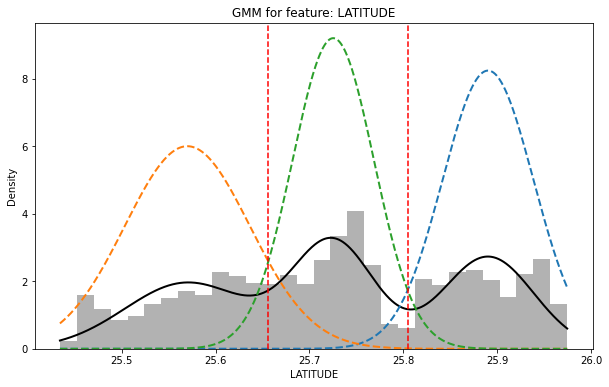

LATITUDE [25.656202360025418, 25.8045507790327]
{'LATITUDE_region3', 'LATITUDE_region1', 'LATITUDE_region2'}


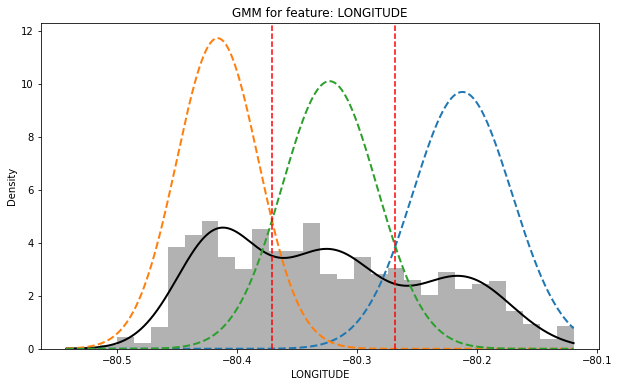

LONGITUDE [-80.37090788955692, -80.268207781114]
{'LONGITUDE_region1', 'LONGITUDE_region3', 'LONGITUDE_region2'}


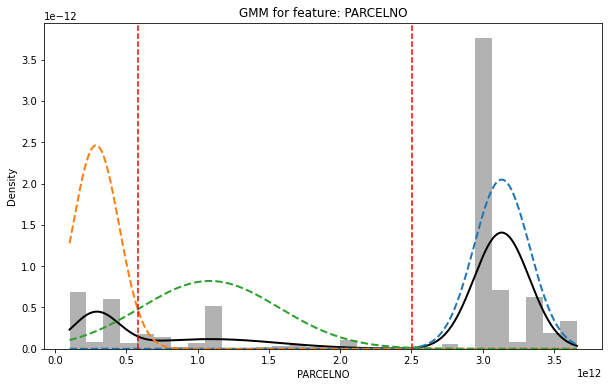

PARCELNO [580814243261.0217, 2505819353728.3843]
{'PARCELNO_region3', 'PARCELNO_region1', 'PARCELNO_region2'}


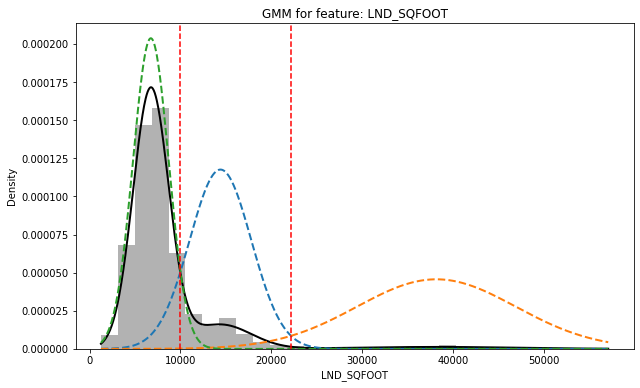

LND_SQFOOT [10001.342795231369, 22163.788748789197]
{'LND_SQFOOT_region1', 'LND_SQFOOT_region3', 'LND_SQFOOT_region2'}


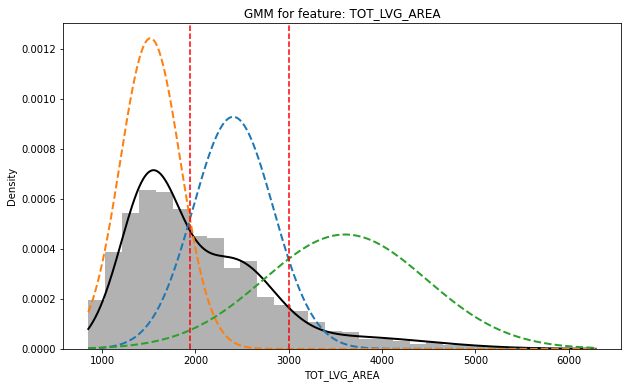

TOT_LVG_AREA [1942.7634426921927, 2998.285819444789]
{'TOT_LVG_AREA_region1', 'TOT_LVG_AREA_region2', 'TOT_LVG_AREA_region3'}


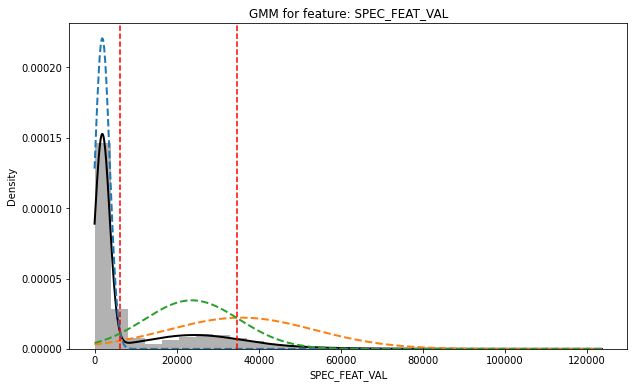

SPEC_FEAT_VAL [6302.808250442021, 34585.83845602742]
{'SPEC_FEAT_VAL_region1', 'SPEC_FEAT_VAL_region3', 'SPEC_FEAT_VAL_region2'}


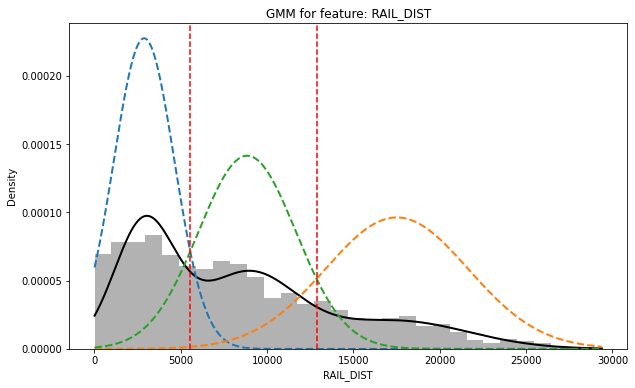

RAIL_DIST [5551.75322975393, 12866.363352574017]
{'RAIL_DIST_region2', 'RAIL_DIST_region3', 'RAIL_DIST_region1'}


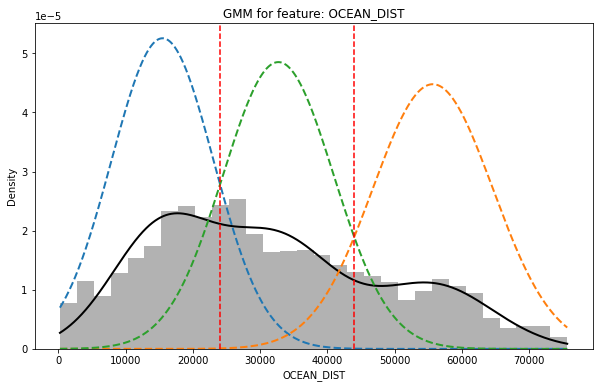

OCEAN_DIST [24048.42978085448, 43994.97567748093]
{'OCEAN_DIST_region2', 'OCEAN_DIST_region3', 'OCEAN_DIST_region1'}


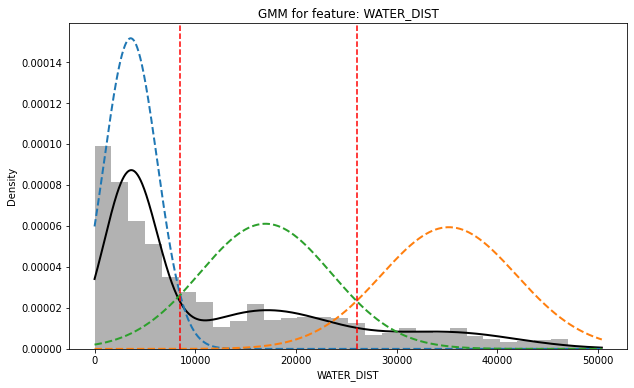

WATER_DIST [8512.03597076386, 26029.803513685383]
{'WATER_DIST_region3', 'WATER_DIST_region2', 'WATER_DIST_region1'}


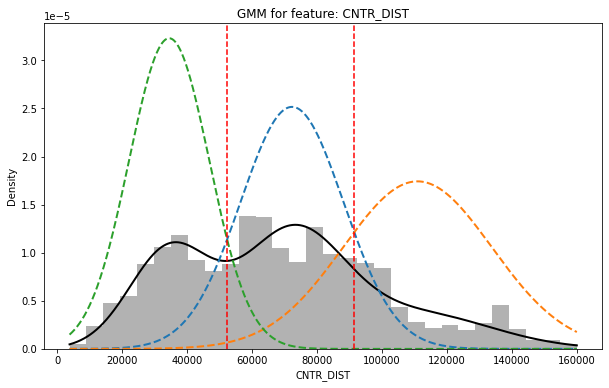

CNTR_DIST [52325.92120391867, 91445.8149345697]
{'CNTR_DIST_region1', 'CNTR_DIST_region2', 'CNTR_DIST_region3'}


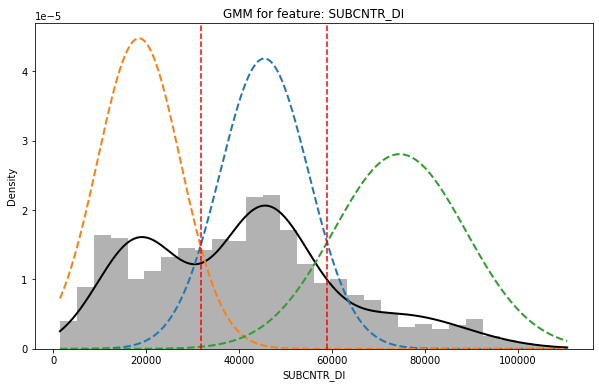

SUBCNTR_DI [31697.34526243281, 58919.693366715655]
{'SUBCNTR_DI_region2', 'SUBCNTR_DI_region3', 'SUBCNTR_DI_region1'}


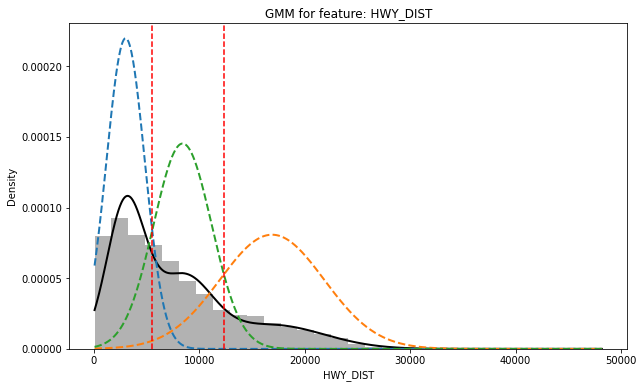

HWY_DIST [5554.8149800183055, 12345.570886471825]
{'HWY_DIST_region2', 'HWY_DIST_region1', 'HWY_DIST_region3'}


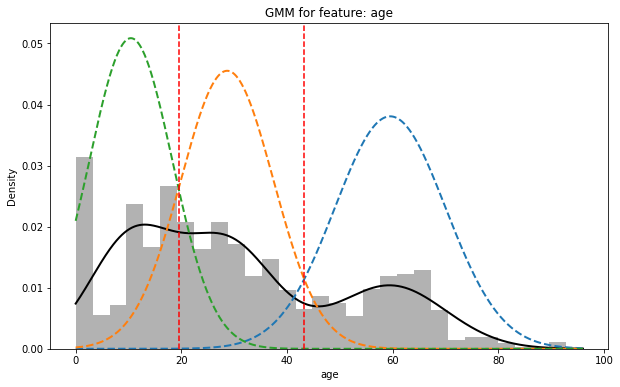

age [19.469365572438182, 43.249578783421974]
{'age_region3', 'age_region1', 'age_region2'}


In [16]:
ft = GMMBinaryMapper(max_gmm_components=3)
#ft = DTRegBinaryMapper(bit = 0, depth=3)
ft.fit(X_train, y_train, plot=True)

In [18]:
ft.no_interaction

[{'LATITUDE_region1', 'LATITUDE_region2', 'LATITUDE_region3'},
 {'LONGITUDE_region1', 'LONGITUDE_region2', 'LONGITUDE_region3'},
 {'PARCELNO_region1', 'PARCELNO_region2', 'PARCELNO_region3'},
 {'LND_SQFOOT_region1', 'LND_SQFOOT_region2', 'LND_SQFOOT_region3'},
 {'TOT_LVG_AREA_region1', 'TOT_LVG_AREA_region2', 'TOT_LVG_AREA_region3'},
 {'SPEC_FEAT_VAL_region1', 'SPEC_FEAT_VAL_region2', 'SPEC_FEAT_VAL_region3'},
 {'RAIL_DIST_region1', 'RAIL_DIST_region2', 'RAIL_DIST_region3'},
 {'OCEAN_DIST_region1', 'OCEAN_DIST_region2', 'OCEAN_DIST_region3'},
 {'WATER_DIST_region1', 'WATER_DIST_region2', 'WATER_DIST_region3'},
 {'CNTR_DIST_region1', 'CNTR_DIST_region2', 'CNTR_DIST_region3'},
 {'SUBCNTR_DI_region1', 'SUBCNTR_DI_region2', 'SUBCNTR_DI_region3'},
 {'HWY_DIST_region1', 'HWY_DIST_region2', 'HWY_DIST_region3'},
 {'age_region1', 'age_region2', 'age_region3'},
 {'avno60plus_0.0', 'avno60plus_1.0'},
 {'month_sold_1.0',
  'month_sold_10.0',
  'month_sold_11.0',
  'month_sold_12.0',
  'month_sold_

In [17]:
X_train_new = ft.transform(X_train)
X_train_new

,LATITUDE_region1,LATITUDE_region2,LATITUDE_region3,LONGITUDE_region1,LONGITUDE_region2,LONGITUDE_region3,PARCELNO_region1,PARCELNO_region2,PARCELNO_region3,LND_SQFOOT_region1,...,month_sold_8.0,month_sold_9.0,month_sold_10.0,month_sold_11.0,month_sold_12.0,structure_quality_1.0,structure_quality_2.0,structure_quality_3.0,structure_quality_4.0,structure_quality_5.0
3046,0,1,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
10415,1,0,0,1,0,0,0,1,0,1,...,0,1,0,0,0,0,1,0,0,0
7292,0,0,1,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
280,0,0,1,0,0,1,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
12813,0,1,0,1,0,0,0,0,1,1,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,0,1,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
3264,0,1,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
9845,1,0,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
10799,1,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0


In [7]:
X_val_new = ft.transform(X_val)

In [8]:
np.sum(np.sum(X_train_new.isna()))

0

In [9]:
np.sum(np.sum(X_val_new.isna()))

0

In [10]:
X_val_new

,LATITUDE_region1,LATITUDE_region2,LONGITUDE_region1,LONGITUDE_region2,PARCELNO_region1,PARCELNO_region2,LND_SQFOOT_region1,LND_SQFOOT_region2,TOT_LVG_AREA_region1,TOT_LVG_AREA_region2,...,month_sold_8.0,month_sold_9.0,month_sold_10.0,month_sold_11.0,month_sold_12.0,structure_quality_1.0,structure_quality_2.0,structure_quality_3.0,structure_quality_4.0,structure_quality_5.0
9415,1,0,1,0,0,1,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
6946,0,1,0,1,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3660,0,1,0,1,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1818,0,1,0,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
10512,1,0,1,0,0,1,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5194,1,0,1,0,0,1,0,1,1,0,...,0,1,0,0,0,0,0,0,1,0
12166,1,0,1,0,0,1,1,0,1,0,...,0,0,0,0,1,0,0,0,1,0
7074,0,1,0,1,0,1,0,1,0,1,...,0,0,1,0,0,0,0,0,0,1
10734,1,0,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
